# Preamble

## Modules

In [1870]:
%matplotlib inline
from collections import defaultdict, Counter
from random import choice, shuffle, random
import subprocess
import re
import itertools
import matplotlib.pylab as plt
import networkx as nx
import community
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
import pandas as pd
from sklearn import metrics
from math import factorial

## Settings

In [2]:
plt.style.use(["classic"])
np.set_printoptions(precision=4)
np.core.arrayprint._line_width = 100

## Functions

## Utility functions

In [2315]:
def write_pajek(A, node_labels=None, index_from=0):
    """Return multiplex representation of multiplex network adjacency matrix A
    
    Providing an adjacency tensor where A[:, :, k] is adjacency matrix of temporal
    layer k, return a pajek format representation of the temporal network which weights interlayer
    edges by state node neighborhood similarity. 
    
    Parameters
    ----------
    A : numpy.3darray
        3d tensor where each A[:, :, k] is a layer adjacency matrix
    max_trans_prob : float/str
        Cap on interlayer edge weights. 'square' for square penalty.
    power_penalty : int/float
        Power to jaccard similarity betw. state nodes to penalize low similarity
    index_from : int
        From which number to index nodes and layers in pajek format from
    style : bool
        Either 'zigzag', 'vertical', or 'simple'. 'vertical' will give working results but is
        essentially wrong use of Infomap, 'simple' should be possible to use in Infomap but is not
        at this point, so 'zigzag' is preferred because it is an explicit representation of the way
        the network should be represented internally in Infomap.

    Returns
    -------
    out_file : string
        A network string in multiplex format
    intid_to_origid : dict
        Key-value pairs of node integer id and original id
    origid_to_intid : dict
        Reverse of intid_to_origid
    """
    
    def _write_outfile(A):
        """Write nodes and intra/inter-edges from A and J to string."""
        def __remove_symmetry_A(A):
            A_triu = defaultdict(int)
            for (i, j, k), w in A.items():
                if j > i:
                    A_triu[(i, j, k)] = w
            return A_triu
        def __write_nodes(outfile):
            outfile += "*Vertices %d" % Nn
            for n in range(Nn):
                label = n if node_labels is None else node_labels[n]
                outfile += '\n%d "%s" 1.0' % (n + index_from, label)
            return outfile
        def __write_intra_edges(outfile):
            outfile += "\n*Intra\n# layer node node [weight]"
            for (i, j, k), w in __remove_symmetry_A(A).items():
                outfile += '\n%d %d %d %f' % (
                    k + index_from,  # layer
                    i + index_from,  # node
                    j + index_from,  # node
                    w                # weight
                )
            return outfile
        
        outfile = ""
        outfile = __write_nodes(outfile)
        outfile = __write_intra_edges(outfile)
        
        return outfile
    
    # Number of nodes and layers
    Nn = max([i for i, j, k in A.keys()]) + 1 - index_from
    Nl = max([k for i, j, k in A.keys()])

    return _write_outfile(A)

def Infomap(pajek_string, *args):
    """Run multiplex community detection because Python implementation has no docs
    
    Parameters
    ----------
    pajek_string : str
        Pajek representation of the network (str)
    *args : dict
        Infomap execution options. (http://www.mapequation.org/code.html#Options)
    Returns
    -------
    communities : list of lists
    layer_communities : data structure in required format for d3 viz (json)
    """
    
    def _get_id_to_label(filename):
        with open('output/' + filename + ".net", 'r') as fp:
            parsed_network = fp.read()
        return dict(
            (int(n.split()[0]), n.split('"')[1])
            for n in parsed_network.split("\n*multiplex")[0].split("\n")[1:]
        )
    
    def _parse_communities(id_to_label, filename):
        with open('output/'+filename+"_expanded.clu", 'r') as infile:
            clusters = infile.read()

        # Get layers, nodes and clusters from _extended.clu file
        la_no_clu = re.findall(r'\d+ \d+ \d+ \d\.\d+', clusters) # ["30 1 2 0.00800543",...]
        la_no_clu = [tuple(i.split()) for i in la_no_clu]

        communities_json = defaultdict(set)
        for layer, node, cluster, _ in la_no_clu:
            communities_json[int(layer)].add((id_to_label[int(node)], int(cluster)))

        return communities_json
    
    def _clean_up(filename):
        subprocess.call(['rm', 'input/'+filename+'.net'])
        subprocess.call(['rm', 'output/'+filename+'_expanded.clu'])
    
    # Get network in multiplex string format and define filename
    filename = 'tmpnet'

    # Store locally
    with open("input/"+filename+".net", 'w') as outfile:
        outfile.write(pajek_string)
    
    # Run Infomap for multiplex network
    subprocess.call(
        ['./infomap/Infomap', 'input/'+filename+".net"] + \
        list(args)
    )
    
    # Parse communities from Infomap output
    id_to_label = _get_id_to_label(filename)
    parsed_communities = _parse_communities(id_to_label, filename)
    _clean_up(filename)

    orig_clu = [item for sublist in parsed_communities.values() for item in sublist]
    communities = dict()
    for key, group in itertools.groupby(orig_clu, lambda x: x[1]):
        for thing in group:
            try:
                communities[key].append(thing[0])
            except KeyError:
                communities[thing[1]] = [thing[0]]
    communities = dict((k,set(v)) for k,v in communities.items())

    layer_communities = {}
    for layer, group in parsed_communities.items():
        communities = {}
        for no, clu in group:
            try:
                communities[clu].append(no)
            except KeyError:
                communities[clu] = [no]
        layer_communities[layer] = communities

    return communities, layer_communities

def default_to_regular(d):
    if isinstance(d, defaultdict):
        d = {k: default_to_regular(v) for k, v in d.iteritems()}
    return d

### Generate toy network

----------------------
**Parameters:**

$N$ is number of nodes

$C$ is number of communities

$D$ is the number of communities that each node participates in.

$<S>$ is the average number of nodes in each community.

$<L>$ is the average number of nodes shared between pairs of communities (the overlap).

----------------------

**Algorithm:**

We define a bipartite graph where one part consists of $C$ communities and the other $N$ nodes, and add $N*D$ edges by the following approach:

* Pick a node $n \in \left\{1, 2, ..., N\right\}$ which as not been picked before
    * For each $d \in \left\{1, 2, ..., D\right\}$ connect $n$ to the community $c \in \left\{1, 2, ..., C\right\}$ that has the smallest number of connections. Impose the constraint that the edge between $n$ and $c$ must minimize the sum of squares (SS) between the average overlap at iteration $t$, $<L_t>$, and the distribution of overlap between pairs of communities $i$ and $j$, thus minimizing:

$$SS_t = \sum_{i, j}^C (<L_t> - L_{t, i, j})^2$$

* Repeat until $ND$ edges have been added to the bipartite graph.

As input to the algorithm, $N$ and $C$ needs to be specified. For the remaining parameters $D$, $<S>$, $<L>$, one and only one needs to be specified.
           
----------------------

**Mathematical properties:**

The average number of nodes in each community is:

$$<S> = \dfrac{N}{C}D$$

In the configuration model, the probability that communities $i$ and $j$ share node $n$ is equivalent to the probability that node $n$ is assigned to both communities $i$ and $j$. This probability will be the number of ways in which $n$ can be assigned to $D$ of the $C$ communities that include $i$ and $j$ divided by the total number possible assignments, given as:

$$p_{i,j,n} = \dfrac{{{C-2}\choose{D-2}}}{{{C}\choose{D}}} = \dfrac{\dfrac{(C-2)!}{(D-2)! ((C-2) - (D-2))!}}{\dfrac{C!}{D! (C - D!)}} = \dfrac{(C-2)!}{C!} \dfrac{D! (C-D)!}{(D-2)! ((C-2) - (D-2))!} = \dfrac{D(D-1)}{C(C-1)}$$

To derive $<L>$ we now need to sum over all nodes for each community pair $i$ and $j$, and divide by the number of terms. In the configuration model, $L_{i,j} = <L>$ so the formula simplifies greatly:

$$<L> = \dfrac{2}{C(C-1)}\sum_n^N \sum_{i, j}^C p_{i,j,n} = \sum_n^N p_{i,j,n} = N \dfrac{D(D-1)}{C(C-1)}$$

From these equations is clear that given either one of $D$, $<S>$ and $<L>$ all can be derived.


In [2312]:
def generate_clustered_temporal_network(N, C, D=None, L=None, S=None, Nl=50, commu_duration=5, density_thr=0.5, debug=False, allow_empty_layers=False, return_entropy_vals=False):
    """Generate synthetic temporal network.
    
    Input
    -----
    N : int
        Number of nodes
    C : int
        Number of communities
    D : int/float
        Average node degree. Cannot be specified simultaneously to L.
    L : int/float
        Average node overlap between communities. Cannot be specified simultaneously to D.
    S : int/float
        Average size of the communities.
    commu_duration : int/2-tuple
        Duration of communities. If two-tuple, draw random number the specified values.
        
    Output
    ------
    layer_commu : dict
        JSON with layers for outer keys, and dicts for values with keys for communities and nodes.
    """
    
    def _compute_S_from_D(N, C, D):
        return N * 1.0 / C * D
    def _compute_L_from_D(N, C, D):
        return N * D * (D - 1) * 1.0 / (C * (C - 1))
    def _compute_D_from_S(N, C, S):
        return S * 1.0 / N * C
    def _compute_L_from_S(N, C, S):
        D = compute_D_from_S(N, C, S)
        return compute_L_from_D(N, C, D)
    def _compute_D_from_L(N, C, L):
        return 0.5 * (N + np.sqrt(4 * C**2 * L * N - 4 * C * L * N + N**2)) * 1.0 / N
    def _compute_S_from_L(N, C, L):
        D = compute_D_from_L(N, C, L)
        return compute_S_from_D(N, C, D)
    
    
    # ----------------------- #
    # Handle input parameters #
    # ----------------------- #
    
    input_params = [D, S, L]
    
    # Throw error if not only one parameter is specified
    if len(filter(lambda param: param is not None, input_params)) != 1:
        raise Exception("One and only one of D, S and L must be specified.")
    
    # Compute unspecified parameters
    param_dict = {0: 'D', 1: 'S', 2: 'L'}
    P = param_dict[[i for i, param in enumerate(input_params) if param != None][0]]
    missing_params = [param for param in param_dict.values() if param != P]

    if D is None:
        D = int(round(locals()['_compute_D_from_' + P](N, C, locals()[P])))
    if S is None:
        S = locals()['_compute_S_from_' + P](N, C, locals()[P])
    if L is None:
        L = locals()['_compute_L_from_' + P](N, C, locals()[P])
        
    if debug:
        print "D", D
        print "S", S
        print "L", L
        
    # Throw error if parameters are not feasible
    if D > C: raise Exception("D cannot be larger than C.")
    if L > N: raise Exception("L cannot be larger than N.")
    if C > N: raise Exception("C cannot be larger than N.")
    
    # Reformat commu_duration to list of possible durations to select from when sampling
    if type(commu_duration) is list:
        commu_duration = range(int(min(commu_duration)), int(max(commu_duration)))
    elif type(commu_duration) in [int, float]:
        commu_duration = [int(commu_duration)]
    

    # --------------------- #
    # Construct communities #
    # --------------------- #
    
    def _choose_community(n, communities, min_len):
        """Under constraints, choose random community to assign n to."""
        choose_from = communities.keys()
        while True:
            cid = choice(choose_from)
            if len(communities[cid]) == min_len and n not in communities[cid]:
                return cid
            else:
                choose_from.remove(cid)
                if choose_from == []:
                    raise Exception('Runs out of communities to assign node to.')

    commu_nodes = defaultdict(list); [commu_nodes[c] for c in range(C)]
    node_ids = range(N)

    for n in range(N):
        for d in range(D):
            min_len = min([len(v) for v in commu_nodes.values()])
            cid = _choose_community(n, commu_nodes, min_len)
            commu_nodes[cid].append(n)
    
    
    # ------------------------- #
    # Place communities in time #
    # ------------------------- #
    
    layer_commu = defaultdict(lambda: defaultdict(list))
    
    # Conditional break parameter and history for avoiding infinte loops
    density = 0
    density_history = []
    
    # Fill in communities until density threshold is reached, or density cannot increase
    while density < density_thr:

        if debug:
            if raw_input() in ["stop", "break", "exit"]:
                break

        # Pick a community
        picked_community = choice(commu_nodes.keys())

        if debug:
            print "Picked community:", picked_community
            print "Member nodes:", commu_nodes[picked_community]

        # Pick a duration and a place in time
        duration = choice(commu_duration)
        layer_start = choice(range(Nl))
        layer_end = layer_start + duration
        layer_end = layer_end if layer_end <= Nl else Nl  # Set ceil of Nl

        if debug:
            print "Duration:", duration, "(", layer_start, "-", layer_end, ")"

        # Check for overlapping nodes
        active_nodes = set()
        for l in range(layer_start, layer_end):
            if l in layer_commu:
                active_nodes.update(layer_commu[l]['nodes'])

        # Restart if any nodes in the picked community are already active
        if len(active_nodes & set(commu_nodes[picked_community])) != 0:
            if debug:
                print "--| nodes already active. RESTART\n"
        else:
            # Add edges to layer_commu datastructure
            for l in range(layer_start, layer_end):
                if len(commu_nodes[picked_community]) < 2:
                    continue
                layer_commu[l]['commu'].append(commu_nodes[picked_community])
                layer_commu[l]['nodes'].extend(commu_nodes[picked_community])

            # Number of nodes added divided by total capacity
            density += duration * len(commu_nodes[picked_community]) * 1.0 / (Nl * N)

            if debug:
                print "--> community successfully added.",
                print "progress:", density / density_thr * 100, "%"
            
        density_history.append(density)
        
        if len(density_history[-10:]) == 10 and len(set(density_history[-10:])) == 1:
            print "Density cannot increase beyond %.2f. Breaking loop." % density
            break
    
    # Fill in empty layers if input parameter specifies it
    if not allow_empty_layers:
        empty_layers = set(range(Nl)) - set(layer_commu.keys())
        for l in empty_layers:
            nearest_non_empty_layer = min(layer_commu.keys(), key=lambda x: abs(x - l))
            layer_commu[l] = layer_commu[nearest_non_empty_layer]
        
    
    # --------------------------------------------------------- #
    # Create adjacency representation and estimate edge entropy #
    # --------------------------------------------------------- #
    
    def _generate_connected_graph(nodes):
        edges = set()
        for i1, n1 in enumerate(nodes):
            for i2, n2 in enumerate(nodes):
                if i2 > i1:
                    edges.add((n1, n2))
        return edges
            
    p_nodes = defaultdict(list)
    A = defaultdict(int)
    for l, commu_nodes in layer_commu.items():
        for commu in commu_nodes['commu']:
            for edge in _generate_connected_graph(commu):
                A[(edge[0], edge[1], l)] += 1
                A[(edge[1], edge[0], l)] += 1
                p_nodes[edge].append(cid)
            cid = hash(str(commu))%300
        
    entropy = []
    for _, coms in sorted(p_nodes.items(), key=lambda kv: kv[0]):
        c_counter = Counter(coms)
        p_arr = np.array(c_counter.values()) * 1.0 / np.sum(c_counter.values())
        _entropy = 1.0 / len(p_nodes) * -np.sum([p * np.log2(p) for p in p_arr])
        entropy.append(_entropy)
    
    if return_entropy_vals:
        return A, layer_commu, entropy
    else:
        return A, layer_commu, np.sum(entropy)


def get_network_in_intervals(entropy_interval, NMI_interval, N=50, C=None, D=None, L=None, S=None, Nl=50, commu_duration=5, density_thr=0.5, return_entropy=False):
    """Return network in desire interval of entropy and obtainable NMI with prediction.
    
    Input
    -----
    entropy_interval : list of length 2 with lower and upper limit on entropy (list)
    NMI_interval : list of length 2 with lower and upper limit on obtainable NMI with prediction (list)
    N : Number of nodes
    Nl : Number of layers
    activation_thr : node density (float)
    
    Output
    ------
    network_pajek : pajek string of the network (str)
    layer_commu : JSON with layers and their communities (dict)
    """
    while True:
        entropy = -np.inf
        while not (entropy_interval[0] <= entropy <= entropy_interval[1]):  # Average 3.5 trials
            A, layer_commu, entropy = generate_clustered_temporal_network(
                N=N,
                C=C,
                D=D,
                L=L,
                S=S,
                Nl=Nl,
                commu_duration=commu_duration,
                density_thr=density_thr,
                debug=False,
                allow_empty_layers=False,
                return_entropy_vals=False
            )

        # Write pajek file
        network_pajek = write_pajek(
            A,
            index_from=0
        )

        # Infomap community detection
        _, layer_commu_pred = Infomap(
            network_pajek,
            'output/',
            '-i',
            'multiplex',
            '--multiplex-js-relax-rate', '0.15',
            '--overlapping',
            '--expanded',
            '--clu',
            '--pajek',
            '--two-level',
            '-z'
        )

        # True
        partition_true = {}
        for l, v in layer_commu.items():
            for c in v['commu']:
                commu_id = str(abs(hash('_'.join(map(str,c)))))
                for n in c:
                    partition_true["%d_%d" % (l, n)] = int(commu_id) % 300
        partition_true = [kv[1] for kv in sorted(partition_true.items(), key=lambda kv: kv[0])]

        # Multiplex Infomap
        partition_pred = {}
        for l, cn in layer_commu_pred.items():
            for c, nn in cn.items():
                for n in nn:
                    partition_pred["%s_%d" % (l, int(n))] = c
        partition_pred = [kv[1] for kv in sorted(partition_pred.items(), key=lambda kv: kv[0])]

        NMI = metrics.cluster.normalized_mutual_info_score(partition_true, partition_pred)
    
        print NMI
        
        if NMI_interval[0] <= NMI <= NMI_interval[1]:
            if return_entropy:
                return network_pajek, layer_commu, entropy
            return network_pajek, layer_commu

# Results

## Similarity links reveal recurrent communities.

### Define functions

In [1308]:
def plot_temporal(ax, cols, partition, layer_commu, annotate=True, offset=0.5):
    """Plot temporal network communities from 2d perspective with fixed node positions."""
    
    nodes = set([n for l in layer_commu.keys() for n in layer_commu[l]['nodes']])
    
    cmap = plt.get_cmap('rainbow')
    
    for l in sorted(layer_commu.keys()):
        rect = mpatches.Rectangle([0, l-offset], Nn, 1, ec="none", lw=0)
        collection = PatchCollection([rect], color="#2c3e50", alpha=0.04*(l%2))
        ax.add_collection(collection)
    
    # Build datastructure of nodes to loop through
    dat = defaultdict(list)
    for l, v in layer_commu.items():
        for c in v['commu']:
            commu_id = str(abs(hash('_'.join(map(str, c)))))
            dat[l].append({
                'commu_id': commu_id,
                'X': c
            })
    
    # Add rectangles
    prev_layer_commus = set()
    for l, d in sorted(dat.items(), key=lambda kv: kv[0]):
        this_layer_commus = set()
        for c in d:
            for x in c['X']:
                #rect = mpatches.Rectangle([x-offset, l-offset], 0.75, 0.75, ec="none", lw=0)
                circ = mpatches.Circle((x-offset+0.5, l-offset+0.5), 0.4, ec="none", lw=0)
                collection = PatchCollection([circ], color=cmap(cols[partition["%d_%d" % (l, x)]]), alpha=0.9)
                ax.add_collection(collection)
            if annotate:
                if c['commu_id'] not in prev_layer_commus:
                    ax.annotate(str(partition["%d_%d" % (l, x)]), xy=(x, l), xytext=(x, l))
            this_layer_commus.add(c['commu_id'])
        prev_layer_commus = this_layer_commus

    plt.xlim([min(nodes)-offset, max(nodes)+1-offset])
    plt.ylim([0, len(layer_commu.keys())])
    
def shuffle_list(l):
    l_out = list(l)[:]
    shuffle(l_out)
    return l_out
    
def get_cols(partition):
    return dict(
        zip(
            shuffle_list(set(partition.values())),
            #set(partition.values()),
            np.linspace(0, 256, len(set(partition.values()))).astype(int)
        )
    )

def clustering_accuracy(partition_t, partition_p):
    """Compute Jaccard similarity of sets of pairs of nodes in same community.
    """
    
    def _get_pairs(partition):
        """Return set of pairs of all nodes assigned same community"""
        tmptable = defaultdict(list)
        for k,v in partition.items():
            tmptable[v].append(k)

        pairs = [tuple(sorted((n1, n2)))
            for commu in tmptable.values()
            for i1, n1 in enumerate(commu)
            for i2, n2 in enumerate(commu) if i2 > i1
            ]

        return set(pairs)
    
    # Get sets of pairs of all nodes assigned same community
    pairs1 = _get_pairs(partition_t)
    pairs2 = _get_pairs(partition_p)
    
    # Return jaccard similarity
    return len(pairs1 & pairs2) * 1.0 / len(pairs1 | pairs2)

### Compute communities

In [2297]:
# Generate toy network
N = 50
Nl = 50
# A, layer_commu, entropy = generate_clustered_temporal_network(
#     Nn=Nn,
#     Nc=20,
#     Nnc=5,#[3,4,5,6,7,8],
#     Nl=Nl,
#     min_dur=3,
#     max_dur=10,
#     activation_thr=0.5,
#     debug=False,-
#     allow_empty_layers=False
# )

# # Write pajek file
# network_pajek = write_pajek(
#     A,
#     index_from=0
# )

entropy_interval, NMI_interval = [-1, 1], [0.1, 1.0]
network_pajek, layer_commu, entropy = get_network_in_intervals(entropy_interval, NMI_interval, N=N, C=25, D=None, L=2, S=None, Nl=Nl, commu_duration=5, density_thr=1.0, return_entropy=True)

0.681250885406


In [2298]:
# Infomap community detection
_, layer_commu_pred_js = Infomap(
    network_pajek,
    'output/',
    '-i',
    'multiplex',
    '--multiplex-js-relax-rate', '0.15',
    '--overlapping',
    '--expanded',
    '--clu',
    '--pajek',
    '--two-level',
    '-z'
)

_, layer_commu_pred_adj = Infomap(
    network_pajek,
    'output/',
    '-i', 'multiplex',
    '--multiplex-relax-rate', '0.15',
    '--multiplex-relax-limit', '1',
    '--overlapping',
    '--expanded',
    '--clu',
    '--pajek',
    '--two-level',
    '-z'
)

### Visualize

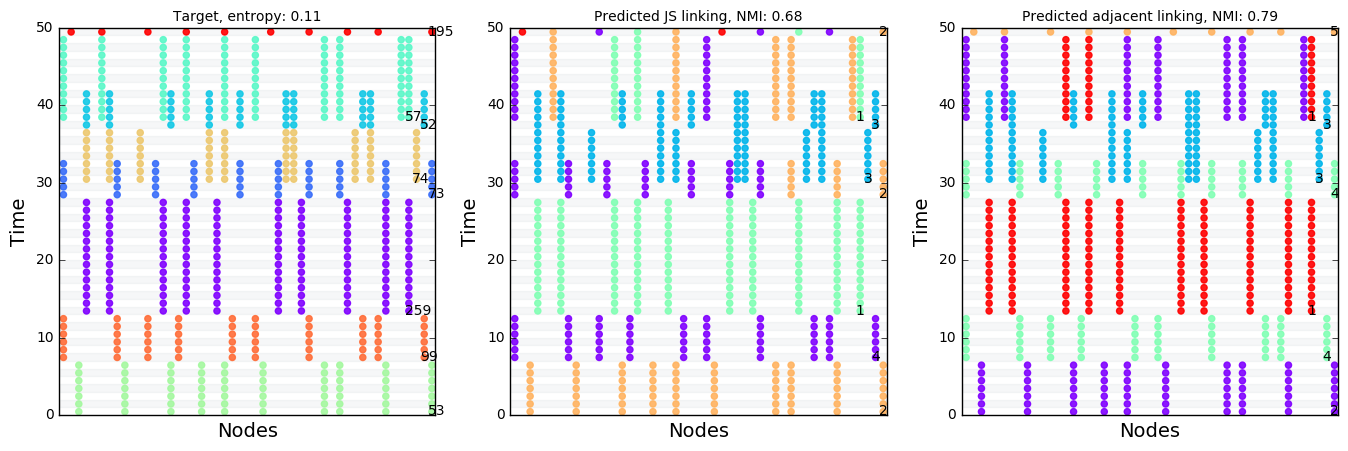

In [2299]:
# True
partition_true = {}
for l, v in layer_commu.items():
    for c in v['commu']:
        commu_id = str(abs(hash('_'.join(map(str,c)))))
        for n in c:
            partition_true["%d_%d" % (l, n)] = int(commu_id) % 300
partition_true_vec = [partition_true[k] for k in sorted(partition_true.keys())]

# Infomap JS links
partition_pred_js = {}
for l, cn in layer_commu_pred_js.items():
    for c, nn in cn.items():
        for n in nn:
            partition_pred_js["%s_%d" % (l, int(n))] = c
partition_pred_js_vec = [partition_pred_js[k] for k in sorted(partition_true.keys())]
            
# Infomap adj links
partition_pred_adj = {}
for l, cn in layer_commu_pred_adj.items():
    for c, nn in cn.items():
        for n in nn:
            partition_pred_adj["%s_%d" % (l, int(n))] = c
partition_pred_adj = dict((k, partition_pred_adj[k]) for k in sorted(partition_true.keys()))
partition_pred_adj_vec = [partition_pred_adj[k] for k in sorted(partition_true.keys())]


# Get colors
cols_true = get_cols(partition_true)
cols_pred_js = get_cols(partition_pred_js)
cols_pred_adj = get_cols(partition_pred_adj)
        
# Plot
plt.figure(figsize=(Nn/10*3.3, Nl/10), frameon=False)

plot_temporal(plt.subplot(131), cols_true, partition_true, layer_commu, annotate=True, offset=0)
plt.title("Target, entropy: %0.2f" % entropy, fontsize=10)
plt.xlabel("Nodes", fontsize=14)
plt.ylabel("Time", fontsize=14)
plt.xticks([])
#plt.axis("off")

plot_temporal(plt.subplot(132), cols_pred_js, partition_pred_js, layer_commu, annotate=True, offset=0)
plt.title("Predicted JS linking, NMI: %0.2f" % metrics.cluster.normalized_mutual_info_score(partition_true_vec, partition_pred_js_vec), fontsize=10)
plt.xlabel("Nodes", fontsize=14)
plt.ylabel("Time", fontsize=14)
plt.xticks([])
#plt.axis("off")

plot_temporal(plt.subplot(133), cols_pred_adj, partition_pred_adj, layer_commu, annotate=True, offset=0)
plt.title("Predicted adjacent linking, NMI: %0.2f" % metrics.cluster.normalized_mutual_info_score(partition_true_vec, partition_pred_adj_vec), fontsize=10)
plt.xlabel("Nodes", fontsize=14)
plt.ylabel("Time", fontsize=14)
plt.xticks([])
#plt.axis("off")

#plt.tight_layout()
#plt.savefig("../figures/mapping_temporal_communities.pdf")
plt.show()

In [ ]:
def generate_connected_graph(nodes):
    edges = []
    for i1, n1 in enumerate(nodes):
        for i2, n2 in enumerate(nodes):
            if i2 > i1:
                edges.append((n1, n2))
    return edges

def draw(G, community_detection=False):
    """Draw graph G in my standard style."""
    
    def _get_cols(partition):
        return dict(
            zip(
                shuffle_list(set(partition.values())),
                np.linspace(0, 256, len(set(partition.values()))).astype(int)
            )
        )

    cmap = plt.get_cmap('rainbow')
    if community_detection:
        partition = community.best_partition(G)
        cols = _get_cols(partition)
        colors = [cmap(cols[partition[n]]) for n in G.nodes()]
    else:
        try:
            colors = [cmap(n[1]['node_color']) for n in G.nodes(data=True)]
        except KeyError:
            # nodes do not have node_color attribute
            colors = "grey"
    
    pos = nx.nx_pydot.graphviz_layout(G, prog='neato')
    nx.draw_networkx_edges(G, pos=pos, width=2, alpha=.3, zorder=-10)
    nx.draw_networkx_nodes(G, pos=pos, node_size=120, alpha=1, linewidths=0, node_color=colors)
    #nx.draw_networkx_labels(G, pos=pos, font_color="red")
    plt.axis("off")

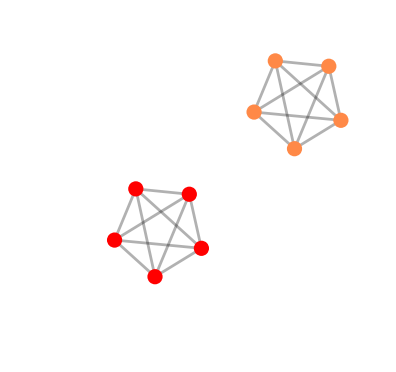

In [10]:
G = nx.Graph()
for cid, nodes in layer_communities[42].items():
    G.add_nodes_from(nodes, node_color=cols_IM[cid])
    G.add_edges_from(generate_connected_graph(nodes))
    
plt.figure(figsize=(4, 4), frameon=False)
draw(G, community_detection=False)
plt.savefig("../figures/mapping_temporal_communities_layer42_graph.pdf")

## NMI vs. entropy

We need to understand how the normalized quality of the clustering scales with the degree of overlap between clusters, measured as normalized mutual information. To this end we simply generate a large number of synthetic networks and measure the correlation between the two metrics.

In [802]:
# Generate toy network
Nn = 50
Nl = 50

X_entr, Y_NMI = [], []

for _iter in range(2000):
    A, layer_commu, entropy = generate_clustered_temporal_network(
        Nn=Nn,
        Nc=20,
        Nnc=5,#[3,4,5,6,7,8],
        Nl=Nl,
        min_dur=3,
        max_dur=10,
        activation_thr=0.5,
        debug=False,
        allow_empty_layers=False
    )

    # Write pajek file
    network_pajek = write_pajek(
        A,
        index_from=0
    )

    # Infomap community detection
    communities, layer_communities = Infomap(
        network_pajek,
        'output/',
        '-i',
        'multiplex',
        '--multiplex-js-relax-rate', '0.15',
        '--overlapping',
        '--expanded',
        '--clu',
        '--pajek',
        '--two-level',
        '-z'
    )
    
    # True
    partition_true = {}
    for l, v in layer_commu.items():
        for c in v['commu']:
            commu_id = str(abs(hash('_'.join(map(str,c)))))
            for n in c:
                partition_true["%d_%d" % (l, n)] = int(commu_id) % 300
    partition_true = [kv[1] for kv in sorted(partition_true.items(), key=lambda kv: kv[0])]

    # Multiplex Infomap
    partition_IM = {}
    for l, cn in layer_communities.items():
        for c, nn in cn.items():
            for n in nn:
                partition_IM["%s_%d" % (l, int(n))] = c
    partition_IM = [kv[1] for kv in sorted(partition_IM.items(), key=lambda kv: kv[0])]
    
    X_entr.append(entropy)
    Y_NMI.append(metrics.cluster.normalized_mutual_info_score(partition_true, partition_IM))

A simple scatter plot shows that the relations is linear:

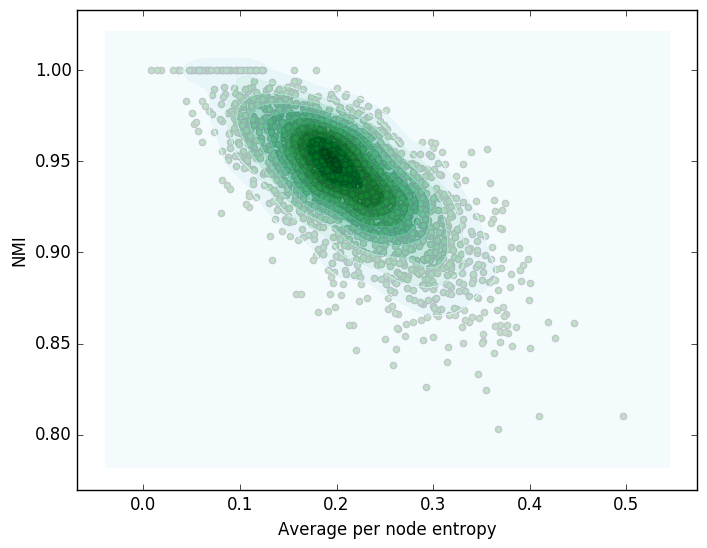

In [807]:
plt.figure(figsize=(8, 6), frameon=False)
plt.scatter(np.array(X_entr), np.array(Y_NMI), alpha=1, c="green")
sns.kdeplot(np.array(X_entr), np.array(Y_NMI), shade=True, alpha=0.8, legend=True)
plt.xlabel("Average per node entropy")
plt.ylabel("NMI")
plt.show()

We now segment the scattered points into segments of width 0.05 and draw the distribution in each. First we show it as points and standard deviations.

In [808]:
entr_NMI = sorted(zip(X_entr, Y_NMI), key=lambda kv: kv[0])
entr_intervals = zip((np.linspace(0, 0.5, 11)+0.025), (np.linspace(0, 0.5, 11)+0.075))

entr_box, NMI_vals, NMI_mean, NMI_std, NMI_err = [], [], [], [], []
for interval in entr_intervals:
    vals = [a for e, a in entr_NMI if interval[0] < e < interval[1]]
    entr_box.append(np.mean(interval))
    NMI_vals.append(vals)
    NMI_mean.append(np.mean(vals))
    NMI_std.append(np.std(vals))
    NMI_err.append(np.std(vals) / np.sqrt(len(vals)))

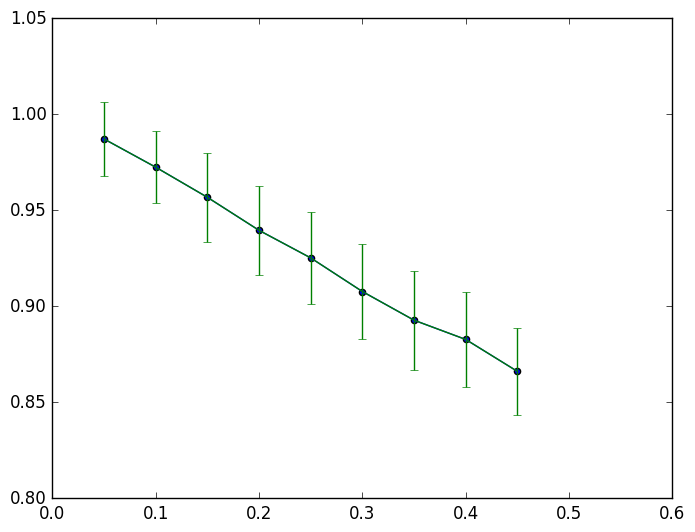

In [809]:
plt.figure(frameon=False)
plt.plot(entr_box, accu_mean)
plt.scatter(entr_box, accu_mean)
plt.errorbar(entr_box, accu_mean, accu_std)
plt.show()

Next we make box plots of each segment. Here it's again very clear that the correlation is linear.

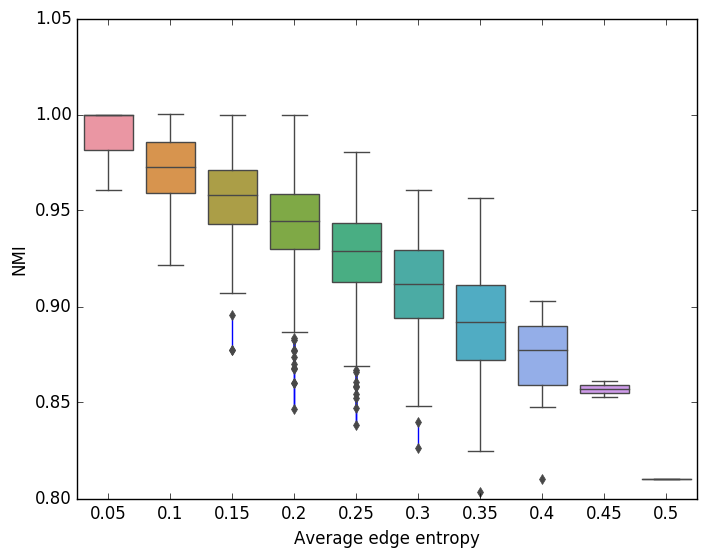

In [813]:
data = pd.DataFrame({
    'NMI': [a for vals in NMI_vals for a in vals],
    'Average edge entropy': [entr for i, entr in enumerate(entr_box) for _ in NMI_vals[i]]
})

plt.figure(frameon=False)
sns.boxplot(x='Average edge entropy', y="NMI", data=data)
plt.show()

**Conclusion:** NMI decays with the average edge entropy. This shows that we should aim to fix the entropy while conducting the further analysis.

## NMI vs. noise

We now sample *N* randomly generated temporal networks with a high entropy rate and accuracy. We aim for sampled networks with high degree of overlap but easily predictable clusters. We then remove edges randomly while recording the accuracy, for each network, to see how the model performs as the temporal network gets more and more sparse.

In [1180]:
def get_network_in_intervals(entropy_interval, NMI_interval, Nn=50, Nl=50):
    while True:
        entropy = 0
        while not (entropy_interval[0] < entropy < entropy_interval[1]):  # Average 3.5 trials
            A, layer_commu, entropy = generate_clustered_temporal_network(
                Nn=Nn,
                Nc=20,
                Nnc=5,#[3,4,5,6,7,8],
                Nl=Nl,
                min_dur=3,
                max_dur=10,
                activation_thr=0.5,
                debug=False,
                allow_empty_layers=False
            )

        # Write pajek file
        network_pajek = write_pajek(
            A,
            index_from=0
        )

        # Infomap community detection
        communities, layer_communities = Infomap(
            network_pajek,
            'output/',
            '-i',
            'multiplex',
            '--multiplex-js-relax-rate', '0.15',
            '--overlapping',
            '--expanded',
            '--clu',
            '--pajek',
            '--two-level',
            '-z'
        )

        # True
        partition_true = {}
        for l, v in layer_commu.items():
            for c in v['commu']:
                commu_id = str(abs(hash('_'.join(map(str,c)))))
                for n in c:
                    partition_true["%d_%d" % (l, n)] = int(commu_id) % 300
        partition_true = [kv[1] for kv in sorted(partition_true.items(), key=lambda kv: kv[0])]

        # Multiplex Infomap
        partition_pred = {}
        for l, cn in layer_communities.items():
            for c, nn in cn.items():
                for n in nn:
                    partition_pred["%s_%d" % (l, int(n))] = c
        partition_pred = [kv[1] for kv in sorted(partition_pred.items(), key=lambda kv: kv[0])]

        NMI = metrics.cluster.normalized_mutual_info_score(partition_true, partition_pred)

        if NMI_interval[0] <= NMI <= NMI_interval[1]:
            return network_pajek, layer_commu

In [1173]:
def remove_random_edge(network, n=1, preserve_bridges=True):
    """Remove random edge from pajek file network without creating more subcomponents or lonely nodes.
    """
    def _pick_random_non_bridge():
        """Draw from the distribution of edges in the network that are not bridges.
        """
        def __layer_graph(layer):
            """Create networkx graph in a given layer.
            """
            G = nx.Graph()
            layer_edges = []
            for index, e in enumerate(edges):
                e = e.split()
                if int(e[0]) == layer:
                    layer_edges.append((e[1], e[2], {'index': index}))
            G.add_edges_from(layer_edges)
            return G

        def __is_bridge(edge):
            """Check whether an edge is a bridge.
            """
            G_copy = G_layer.copy()
            num_components_pre = len(list(nx.connected_component_subgraphs(G_copy)))
            G_copy.remove_edge(edge[0], edge[1])
            num_components_post = len(list(nx.connected_component_subgraphs(G_copy)))
            if num_components_post > num_components_pre:
                return True
            else:
                return False
            
        def __creates_nonely_node(edge):
            G_copy = G_layer.copy()
            G_copy.remove_edge(edge[0], edge[1])
            if 0 in G_copy.degree().values():
                return True
            else:
                return False
        
        candidate_layer = choice(layers)
        #print "\nchoosing candidate layer", candidate_layer
        tried_layers = set([candidate_layer])
        G_layer = __layer_graph(candidate_layer)
    
        while True:
            candidate_edges = [
                e
                for e in G_layer.edges(data=True)
                if e[:-1] not in bridges[candidate_layer]
            ]
            
            if len(candidate_edges) > 0:
                candidate_edge = choice(candidate_edges)
                #print "\t choosing candidate edge", candidate_edge

                if preserve_bridges and not __is_bridge(candidate_edge):
                    #print "\t\t**success! candidate removed without creating bridges**" 
                    return candidate_edge[2]['index']
                elif not preserve_bridges and not __creates_nonely_node(candidate_edge):
                    return candidate_edge[2]['index']
                else:
                    bridges[candidate_layer].append(candidate_edge[:-1])
                    #print "\t\t>>failed! candidate creates bridge<<" 

            else: 
                if len(tried_layers) == len(layers):
                    #print "cannot remove more edges from temporal network"
                    return -1
                #print "no candidates in this layer"
                candidate_layer = choice(list(set(layers) - tried_layers))
                #print "\nchoosing candidate layer", candidate_layer
                tried_layers.update([candidate_layer])
                G_layer = __layer_graph(candidate_layer)
                
                
    def _remove_edge_from_network(_network, edge):
        """Remove edge from network pajek string.
        """
        _network_split = _network.split("\n")
        _network_split.remove(edge)
        return "\n".join(_network_split)
    
    
    edges = re.findall(r"\d+ \d+ \d+ \d\.\d+", network)
    num_edges = len(edges)
    layers = sorted(set([int(e.split()[0]) for e in edges]))
    bridges = defaultdict(list)
    
    edges_removed = 0
    while edges_removed < num_edges:
        #print sum([len(list(nx.connected_component_subgraphs(_layer_graph(l)))) for l in layers])  # ensure that total number of connected components remain the same
        yield network, edges_removed * 1.0 / num_edges
        for _ in range(n):
            remove_edge_index = _pick_random_non_bridge()
            if remove_edge_index == -1: raise StopIteration
            network = _remove_edge_from_network(network, edges[remove_edge_index])
            del edges[remove_edge_index]
            edges_removed += 1
           
        
def swap_random_edges(network, n=1, thr=1e-3):
    """Swap two random edge from pajek file.
    """
    def _remove_edge_from_network(_network, edge):
        """Remove edge from network pajek string.
        """
        _network_split = _network.split("\n")
        _network_split.remove(edge)
        return "\n".join(_network_split)
    
    def _swap_two_edges(_network, layer):
        edges_layer = [e for e in edges if int(e.split()[0]) == layer]
        
        edge1 = choice(edges_layer); edges_layer.remove(edge1)
        edge2 = choice(edges_layer)
        
        edge1_new = " ".join([v if i != 2 else edge2.split()[2] for i, v in enumerate(edge1.split())])
        edge2_new = " ".join([v if i != 2 else edge1.split()[2] for i, v in enumerate(edge2.split())])
        
        _network = _remove_edge_from_network(_network, edge1)
        _network = _remove_edge_from_network(_network, edge2)
        
        _network += "\n" + edge1_new
        _network += "\n" + edge2_new
        
        return _network
        
    edges = re.findall(r"\d+ \d+ \d+ \d\.\d+", network)
    layers = sorted(set([int(e.split()[0]) for e in edges]))

    num_edges = len(edges)
    num_swaps = 0
    
    while (num_swaps * 1.0 / num_edges) < 1.0:
        yield network, num_swaps * 1.0 / num_edges
        for _ in range(n):
            network = _swap_two_edges(network, choice(layers))
            edges = re.findall(r"\d+ \d+ \d+ \d\.\d+", network)
            num_swaps += 2

In [ ]:
def worker(network_generator, _partition_true):
    NMI_i_js, NMI_i_adj, p_i = [], [], []
    for network_iteration, p in network_generator:
        # Infomap community detection
        _, layer_commu_pred_js = Infomap(
            network_iteration,
            'output/',
            '-i', 'multiplex',
            '--multiplex-js-relax-rate', '0.15',
            '--overlapping',
            '--expanded',
            '--clu',
            '--pajek',
            '--two-level',
            '-z'
        )
        
        _, layer_commu_pred_adj = Infomap(
            network_iteration,
            'output/',
            '-i', 'multiplex',
            '--multiplex-relax-rate', '0.15',
            '--multiplex-relax-limit', '1',
            '--overlapping',
            '--expanded',
            '--clu',
            '--pajek',
            '--two-level',
            '-z'
        )
        
        # True partition
        _partition_true_vec = [_partition_true[n] for n in sorted(_partition_true.keys())]

        # Predicted partition using Jensen-Shannon divergence links
        partition_pred_js = {}
        for l, cn in layer_commu_pred_js.items():
            for c, nn in cn.items():
                for n in nn:
                    partition_pred_js["%s_%d" % (l, int(n))] = c
        partition_pred_vec_js = [partition_pred_js[n] for n in sorted(_partition_true.keys())]
        
        # Predicted partition using adjacent layer links
        partition_pred_adj = {}
        for l, cn in layer_commu_pred_adj.items():
            for c, nn in cn.items():
                for n in nn:
                    partition_pred_adj["%s_%d" % (l, int(n))] = c
        partition_pred_vec_adj = [partition_pred_adj[n] for n in sorted(_partition_true.keys())]

        NMI_i_js.append(metrics.cluster.normalized_mutual_info_score(_partition_true_vec, partition_pred_vec_js))
        NMI_i_adj.append(metrics.cluster.normalized_mutual_info_score(_partition_true_vec, partition_pred_vec_adj))
        p_i.append(p)
        
    return NMI_i_js, NMI_i_adj, p_i

entropy_interval = [0.2, 0.225]
NMI_interval = [0.975, 1.0]

# NMI_js_matr_bridges_preserved = []
# NMI_adj_matr_bridges_preserved = []
# p_matr_bridges_preserved = []

# NMI_js_matr_bridges_not_preserved = []
# NMI_adj_matr_bridges_not_preserved = []
# p_matr_bridges_not_preserved = []

# NMI_js_matr_edge_swaps = []
# NMI_adj_matr_edge_swaps = []
# p_matr_edge_swaps = []

for i in range(1000):
    network_pajek, layer_commu = get_network_in_intervals(entropy_interval, NMI_interval)

    # True partition
    partition_true = {}
    for l, v in layer_commu.items():
        for c in v['commu']:
            commu_id = str(abs(hash('_'.join(map(str, c)))))
            for n in c:
                partition_true["%d_%d" % (l, n)] = int(commu_id) % 300

    # Bridges preserved
    network_generator = remove_random_edge(network_pajek, n=10, preserve_bridges=True)
    NMI_i_js, NMI_i_adj, p_i = worker(network_generator, partition_true)
    NMI_js_matr_bridges_preserved.append(NMI_i_js)
    NMI_adj_matr_bridges_preserved.append(NMI_i_adj)
    p_matr_bridges_preserved.append(p_i)
    
    # Bridges not preserved
    network_generator = remove_random_edge(network_pajek, n=10, preserve_bridges=False)
    NMI_i_js, NMI_i_adj, p_i = worker(network_generator, partition_true)    
    NMI_js_matr_bridges_not_preserved.append(NMI_i_js)
    NMI_adj_matr_bridges_not_preserved.append(NMI_i_adj)
    p_matr_bridges_not_preserved.append(p_i)
    
    # Intralayer edge swaps
    network_generator = swap_random_edges(network_pajek, n=10)
    NMI_i_js, NMI_i_adj, p_i = worker(network_generator, partition_true)    
    NMI_js_matr_edge_swaps.append(NMI_i_js)
    NMI_adj_matr_edge_swaps.append(NMI_i_adj)
    p_matr_edge_swaps.append(p_i)

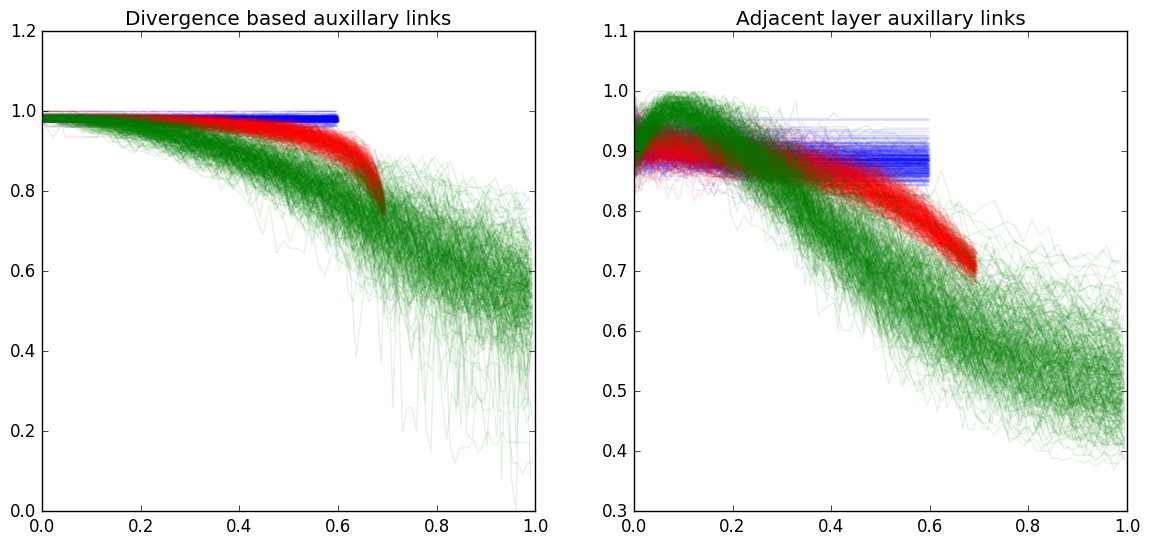

In [1207]:
plt.figure(figsize=(14, 6), frameon=False)

plt.subplot(1,2,1)
plt.title("Divergence based auxillary links")
for p_i, NMI_i in zip(p_matr_bridges_preserved, NMI_js_matr_bridges_preserved):
    plt.plot(p_i, NMI_i, c="b", alpha=0.1)
for p_i, NMI_i in zip(p_matr_bridges_not_preserved, NMI_js_matr_bridges_not_preserved):
    plt.plot(p_i, NMI_i, c="r", alpha=0.1)
for p_i, NMI_i in zip(p_matr_edge_swaps, NMI_js_matr_edge_swaps):
    plt.plot(p_i, NMI_i, c="g", alpha=0.1)
    
plt.subplot(1,2,2)
plt.title("Adjacent layer auxillary links")
for p_i, NMI_i in zip(p_matr_bridges_preserved, NMI_adj_matr_bridges_preserved):
    plt.plot(p_i, NMI_i, c="b", alpha=0.1)
for p_i, NMI_i in zip(p_matr_bridges_not_preserved, NMI_adj_matr_bridges_not_preserved):
    plt.plot(p_i, NMI_i, c="r", alpha=0.1)
for p_i, NMI_i in zip(p_matr_edge_swaps, NMI_adj_matr_edge_swaps):
    plt.plot(p_i, NMI_i, c="g", alpha=0.1)

plt.show()

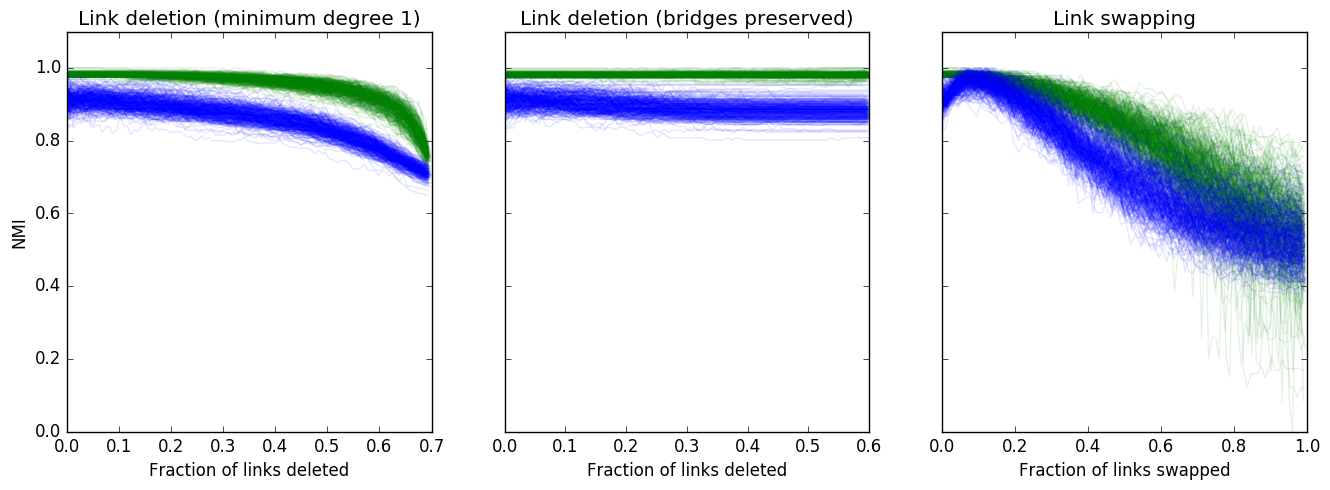

In [1232]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5), sharey=True, frameon=False)

ax1.set_title("Link deletion (minimum degree 1)")
ax1.set_xlabel("Fraction of links deleted"); ax1.set_ylabel("NMI")
for p_i, NMI_i in zip(p_matr_bridges_not_preserved, NMI_js_matr_bridges_not_preserved):
    ax1.plot(p_i, NMI_i, c="g", alpha=0.1)
for p_i, NMI_i in zip(p_matr_bridges_not_preserved, NMI_adj_matr_bridges_not_preserved):
    ax1.plot(p_i, NMI_i, c="b", alpha=0.1)
    
ax2.set_title("Link deletion (bridges preserved)")
ax2.set_xlabel("Fraction of links deleted")
for p_i, NMI_i in zip(p_matr_bridges_preserved, NMI_js_matr_bridges_preserved):
    ax2.plot(p_i, NMI_i, c="g", alpha=0.1)
for p_i, NMI_i in zip(p_matr_bridges_preserved, NMI_adj_matr_bridges_preserved):
    ax2.plot(p_i, NMI_i, c="b", alpha=0.1)
    
ax3.set_title("Link swapping")
ax3.set_xlabel("Fraction of links swapped")
for p_i, NMI_i in zip(p_matr_edge_swaps, NMI_js_matr_edge_swaps):
    ax3.plot(p_i, NMI_i, c="g", alpha=0.1)
for p_i, NMI_i in zip(p_matr_edge_swaps, NMI_adj_matr_edge_swaps):
    ax3.plot(p_i, NMI_i, c="b", alpha=0.1)

plt.ylim([0, 1.1])
plt.show()

## NMI time dilution

We now investigate how the NMI is diluted for our approach and traditional adjacent linking, as the number of layers increase

In [1439]:
entropy_interval, NMI_interval = [0.14, 0.16], [1.0, 1.0]
network_pajek, layer_commu, entropy = get_network_in_intervals(entropy_interval, NMI_interval, return_entropy=True)

In [1460]:
def dublicate_network_layers(_network, layer_commu, N=1):
    """Repeat temporal _network N times in time direction.
    
    Input
    -----
    _network : pajek formattet _network only containing intralayer links in 'layer node node weight' format (str).
    
    Output
    -----
    _network : input _network repeated once in time direction (str).
    """

    edges = re.findall(r"\d+ \d+ \d+ \d\.\d+", _network)
    layers = sorted(set([int(e.split()[0]) for e in edges]))
    
    # Make copy of _layer_commu to avoid global inline insertion
    _layer_commu = layer_commu.copy()

    for n in range(1, N+1):
        new_layers = range(len(layers)*n, len(layers)*(n+1))
        layer_map = dict(zip(layers, new_layers))
        new_edges = []
        for e in edges:
            e = e.split()
            new_edges.append(
                " ".join([str(layer_map[int(e[0])])] + e[1:])
            )
        for l in layer_commu.keys():
            _layer_commu[layer_map[l]] = _layer_commu[l]

        _network += "\n" + "\n".join(new_edges)    
    return _network, _layer_commu

In [ ]:
# NMI_js_matr = []
# NMI_adj_matr = []
# NMI_uni_matr = []
# Nl_js_adj_matr = []

for multiplication_factor in range(len(NMI_uni_matr), len(Nl_js_adj_matr)):
    
#     if Nl * (1+multiplication_factor) in Nl_js_adj_matr:
#         continue
    
    print multiplication_factor
    
    _network, _layer_commu = dublicate_network_layers(network_pajek, layer_commu, multiplication_factor)
    
    # Infomap community detection
#     _, layer_commu_pred_js = Infomap(
#         _network,
#         'output/',
#         '-i',
#         'multiplex',
#         '--multiplex-js-relax-rate', '0.15',
#         '--overlapping',
#     #    '--preferred-number-of-modules', '2', 
#         '--expanded',
#         '--clu',
#         '--pajek',
#         '--two-level',
#         '-z'
#     )

#     _, layer_commu_pred_adj = Infomap(
#         _network,
#         'output/',
#         '-i', 'multiplex',
#         '--multiplex-relax-rate', '0.15',
#         '--multiplex-relax-limit', '1',
#         '--overlapping',
#         '--expanded',
#         '--clu',
#         '--pajek',
#         '--two-level',
#         '-z'
#     )
    
    _, layer_commu_pred_uni = Infomap(
        _network,
        'output/',
        '-i', 'multiplex',
        '--multiplex-relax-rate', '0.15',
        '--multiplex-relax-limit', '-1',
        '--overlapping',
        '--expanded',
        '--clu',
        '--pajek',
        '--two-level',
        '-z'
    )
    
    partition_true = {}
    for l, v in _layer_commu.items():
        for c in v['commu']:
            commu_id = str(abs(hash('_'.join(map(str,c)))))
            for n in c:
                partition_true["%d_%d" % (l, n)] = int(commu_id) % 300
    partition_true_vec = [partition_true[k] for k in sorted(partition_true.keys())]

    # Infomap JS links
#     partition_pred_js = {}
#     for l, cn in layer_commu_pred_js.items():
#         for c, nn in cn.items():
#             for n in nn:
#                 partition_pred_js["%s_%d" % (l, int(n))] = c
#     partition_pred_vec_js = [partition_pred_js[k] for k in sorted(partition_true.keys())]

    # Infomap adj links
#     partition_pred_adj = {}
#     for l, cn in layer_commu_pred_adj.items():
#         for c, nn in cn.items():
#             for n in nn:
#                 partition_pred_adj["%s_%d" % (l, int(n))] = c
#     partition_pred_adj = dict((k, partition_pred_adj[k]) for k in sorted(partition_true.keys()))
#     partition_pred_vec_adj = [partition_pred_adj[k] for k in sorted(partition_true.keys())]
    
    # Infomap uni links
    partition_pred_uni = {}
    for l, cn in layer_commu_pred_uni.items():
        for c, nn in cn.items():
            for n in nn:
                partition_pred_uni["%s_%d" % (l, int(n))] = c
    partition_pred_uni = dict((k, partition_pred_uni[k]) for k in sorted(partition_true.keys()))
    partition_pred_vec_uni = [partition_pred_uni[k] for k in sorted(partition_true.keys())]
    
    #NMI_js_matr.append(metrics.cluster.normalized_mutual_info_score(partition_true_vec, partition_pred_vec_js))
#     NMI_js_matr.append(1.0)
#     NMI_adj_matr.append(metrics.cluster.normalized_mutual_info_score(partition_true_vec, partition_pred_vec_adj))
    NMI_uni_matr.append(metrics.cluster.normalized_mutual_info_score(partition_true_vec, partition_pred_vec_uni))
#     Nl_js_adj_matr.append(Nl * (1+multiplication_factor))

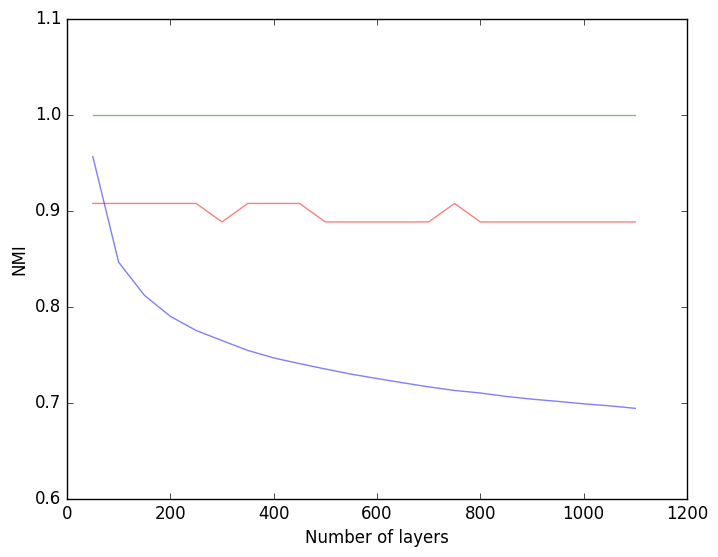

In [1489]:
plt.figure(frameon=False)
plt.plot(Nl_js_adj_matr[:len(NMI_uni_matr)], NMI_js_matr[:len(NMI_uni_matr)], c="green", alpha=0.5)
plt.plot(Nl_js_adj_matr[:len(NMI_uni_matr)], NMI_adj_matr[:len(NMI_uni_matr)], c="blue", alpha=0.5)
plt.plot(Nl_js_adj_matr[:len(NMI_uni_matr)], NMI_uni_matr, c="red", alpha=0.5)
plt.ylim([0.6, 1.1])
plt.xlabel("Number of layers")
plt.ylabel("NMI")
plt.show()
